# Task 2 : Classical Graph Neural Network (GNN) Part

For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available here with its corresponding description.
- Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges.
- Discuss the resulting performance of the 2 chosen architectures.


## Loading the dataset

In [1]:
!wget https://zenodo.org/record/3164691/files/QG_jets.npz?download=1 -O QG_jets.npz

--2024-03-21 07:47:39--  https://zenodo.org/record/3164691/files/QG_jets.npz?download=1
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3164691/files/QG_jets.npz [following]
--2024-03-21 07:47:40--  https://zenodo.org/records/3164691/files/QG_jets.npz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 106689379 (102M) [application/octet-stream]
Saving to: ‘QG_jets.npz’

QG_jets.npz         100%[===================>] 101.75M  3.72MB/s    in 32s     

2024-03-21 07:48:13 (3.16 MB/s) - ‘QG_jets.npz’ saved [106689379/106689379]



In [3]:
!pip install  dgl -f https://data.dgl.ai/wheels/cu121/repo.html

Looking in links: https://data.dgl.ai/wheels/cu121/repo.html


In [4]:
!pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

Looking in links: https://data.dgl.ai/wheels-test/repo.html


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve
import dgl
import torch
import networkx as nx
%matplotlib inline

In [6]:
with np.load('./QG_jets.npz') as data:
    X = data['X']
    y_train = data['y']
print(X.shape)
print(y_train.shape)

(100000, 139, 4)
(100000,)


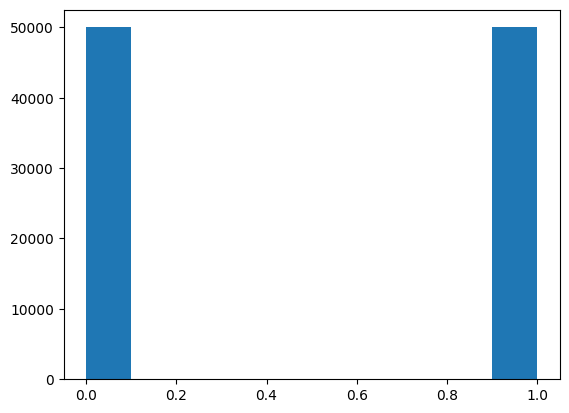

In [7]:
plt.hist(y_train)
plt.show()

In [8]:
x_train = []
for i in X:
    x_train.append(i[0])
x_train = np.array(x_train)
print(x_train.shape)

(100000, 4)


Approach:

I have used the following two graph-based architectures:

1. Node Classification
2. Graph Classification

### Node Classification
In this approach, I have encoded the data as nodes of a graph and then train a GNN to learn to classify these nodes. In this way we can build a classifier which classifies quarks from gluons.

### Graph Classification
In this approach, I have encoded each training sample as a graph, resulting in a training data of different graphs. I will then train a GNN to learn to classify different graphs. In this way too we can build a classifier which classifies quarks from gluons.

## Node Classification

### Dataset preprocessing

I have used a small subset of the original dataset here.

In [9]:
x_train_small = x_train[:2000].astype(np.float32)
y_train_small = y_train[:2000]
class NodeClassificationDataset(dgl.data.DGLDataset):
    """A Class to process and convert the numpy training data into Graphs so that it can be used in GNNs"""
    def __init__(self):
        super().__init__(name='node_classification')
        self.num_classes = 2

    def process(self):
        node_features = torch.from_numpy(x_train_small)
        node_labels = torch.from_numpy(y_train_small).long()

        self.graph = dgl.from_networkx(nx.generators.fast_gnp_random_graph(x_train_small.shape[0], 0.008, seed=1337))
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels
        # self.graph.ndata['weight'] = None

        n_nodes = x_train_small.shape[0]
        n_train = int(n_nodes * 0.8)
        n_val = int(n_nodes * 0.1)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train:n_train+n_val] = True
        test_mask[n_train+n_val:] = True
        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask
        self.graph.ndata['test_mask'] = test_mask

    def __getitem__(self, idx):
        return self.graph
    def __len__(self):
        return 1

node_classif_dataset = NodeClassificationDataset()
node_classif_graph = node_classif_dataset[0]

In [10]:
print(node_classif_graph)

Graph(num_nodes=2000, num_edges=31988,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})


## Model Definition

In [11]:
from dgl.nn import GraphConv
class NodeClassificationModel(torch.nn.Module):
    def __init__(self, in_feats, num_classes):
        super(NodeClassificationModel, self).__init__()
        self.conv1 = GraphConv(in_feats, 16)
        self.conv2 = GraphConv(16, 32)
        self.conv3 = GraphConv(32, 64)
        self.conv4 = GraphConv(64, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = torch.nn.functional.elu(h)
        h = self.conv2(g, h)
        h = torch.nn.functional.relu(h)
        h = self.conv3(g, h)
        h = torch.nn.functional.relu(h)
        h = self.conv4(g, h)
        return h

node_classif_model = NodeClassificationModel(node_classif_graph.ndata['feat'].shape[1], node_classif_dataset.num_classes)

## Training Loop

In [12]:
def train(g, model, num_epochs):
    losses = []
    accs = {'train':[], 'val':[], 'test':[]}
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, betas=(0.6, 0.7))
    best_val_acc = 0.0
    best_test_acc = 0.0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    test_mask = g.ndata['test_mask']
    val_mask = g.ndata['val_mask']

    for e in range(num_epochs):
        model.train()
        logits = model(g, features)
        preds = logits.argmax(1)

        loss = torch.nn.functional.cross_entropy(logits[train_mask], labels[train_mask])

        train_acc = (preds[train_mask] == labels[train_mask]).float().mean()
        val_acc = (preds[val_mask] == labels[val_mask]).float().mean()
        test_acc = (preds[test_mask] == labels[test_mask]).float().mean()

        losses.append(loss)
        accs['train'].append(train_acc)
        accs['test'].append(test_acc)
        accs['val'].append(val_acc)

        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        with torch.no_grad():
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if e % 5 == 0:
            print('In epoch {}, loss: {:.8f}, val acc: {:.8f} (best {:.8f}), test acc: {:.8f} (best {:.8f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
    return losses, accs

In [13]:
node_classif_graph = node_classif_graph.to('cuda')
node_classif_model = node_classif_model.to('cuda')
node_classif_losses, node_classif_accs = train(node_classif_graph, node_classif_model, 5000)

In epoch 0, loss: 2.94084048, val acc: 0.47999999 (best 0.47999999), test acc: 0.52499998 (best 0.52499998)
In epoch 5, loss: 2.87939525, val acc: 0.47999999 (best 0.47999999), test acc: 0.52499998 (best 0.52499998)
In epoch 10, loss: 2.81805778, val acc: 0.47999999 (best 0.47999999), test acc: 0.52499998 (best 0.52499998)
In epoch 15, loss: 2.75683165, val acc: 0.47999999 (best 0.47999999), test acc: 0.52499998 (best 0.52499998)
In epoch 20, loss: 2.69572663, val acc: 0.47999999 (best 0.47999999), test acc: 0.52499998 (best 0.52499998)
In epoch 25, loss: 2.63474631, val acc: 0.47999999 (best 0.47999999), test acc: 0.52499998 (best 0.52499998)
In epoch 30, loss: 2.57390571, val acc: 0.47999999 (best 0.47999999), test acc: 0.52499998 (best 0.52499998)
In epoch 35, loss: 2.51322150, val acc: 0.47999999 (best 0.47999999), test acc: 0.52499998 (best 0.52499998)
In epoch 40, loss: 2.45270634, val acc: 0.47999999 (best 0.47999999), test acc: 0.52499998 (best 0.52499998)
In epoch 45, loss: 2.

In [14]:
node_classif_accs['val'] = [t.cpu().detach().numpy() for t in node_classif_accs['val']]

In [15]:
node_classif_accs['test'] = [t.cpu().detach().numpy() for t in node_classif_accs['test']]

In [21]:
node_classif_accs['train'] = [t.cpu().detach().numpy() for t in node_classif_accs['train']]

In [22]:
node_classif_accs['train']

[array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0.4825, dtype=float32),
 array(0

In [23]:
node_classif_losses_numpy = [t.cpu().detach().numpy() for t in node_classif_losses]

In [24]:
node_classif_losses_numpy

[array(2.9408405, dtype=float32),
 array(2.928544, dtype=float32),
 array(2.91625, dtype=float32),
 array(2.9039602, dtype=float32),
 array(2.8916748, dtype=float32),
 array(2.8793952, dtype=float32),
 array(2.8671181, dtype=float32),
 array(2.8548474, dtype=float32),
 array(2.8425791, dtype=float32),
 array(2.8303168, dtype=float32),
 array(2.8180578, dtype=float32),
 array(2.8058028, dtype=float32),
 array(2.7935529, dtype=float32),
 array(2.7813087, dtype=float32),
 array(2.7690668, dtype=float32),
 array(2.7568316, dtype=float32),
 array(2.7445998, dtype=float32),
 array(2.7323754, dtype=float32),
 array(2.7201545, dtype=float32),
 array(2.707938, dtype=float32),
 array(2.6957266, dtype=float32),
 array(2.6835208, dtype=float32),
 array(2.6713183, dtype=float32),
 array(2.6591222, dtype=float32),
 array(2.6469312, dtype=float32),
 array(2.6347463, dtype=float32),
 array(2.6225672, dtype=float32),
 array(2.6103933, dtype=float32),
 array(2.5982244, dtype=float32),
 array(2.586063, d

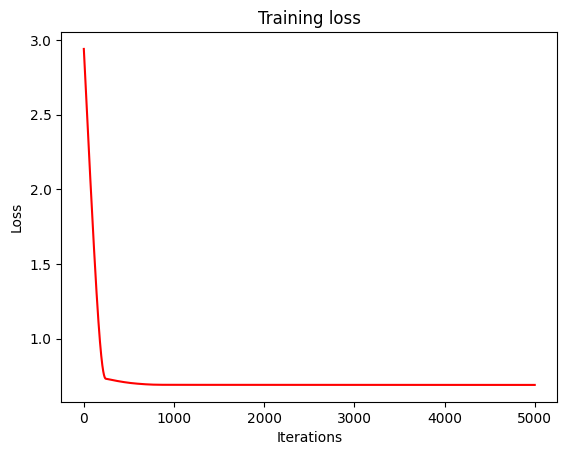

In [25]:
plt.plot(node_classif_losses_numpy, 'r-')
plt.title('Training loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

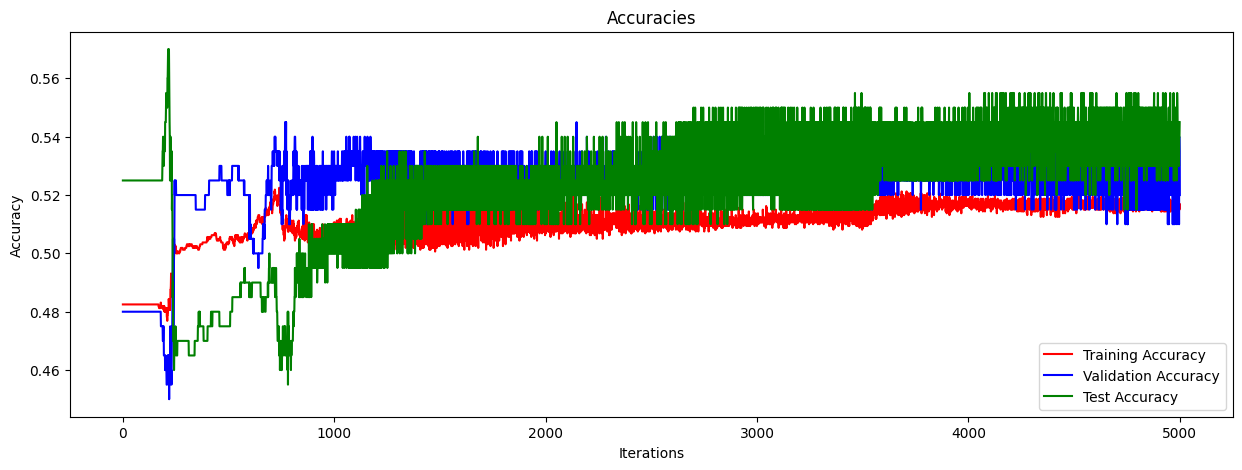

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(node_classif_accs['train'], 'r-', label='Training Accuracy')
plt.plot(node_classif_accs['val'], 'b-', label='Validation Accuracy')
plt.plot(node_classif_accs['test'], 'g-', label='Test Accuracy')
plt.title('Accuracies')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
logits = node_classif_model(node_classif_graph, node_classif_graph.ndata['feat'])
pred = logits.argmax(1)

In [28]:
pred

tensor([1, 0, 1,  ..., 1, 1, 1], device='cuda:0')

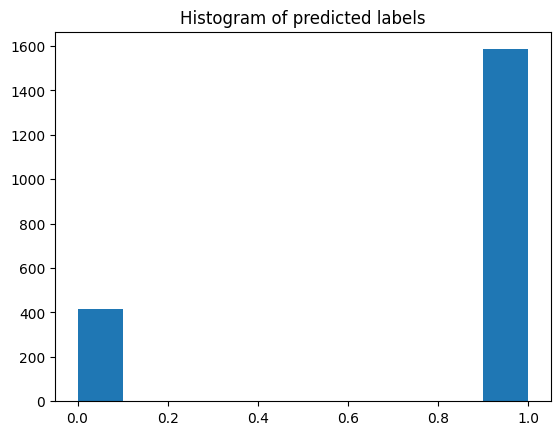

In [29]:
plt.hist(pred.cpu().detach().numpy())
plt.title('Histogram of predicted labels')
plt.show()

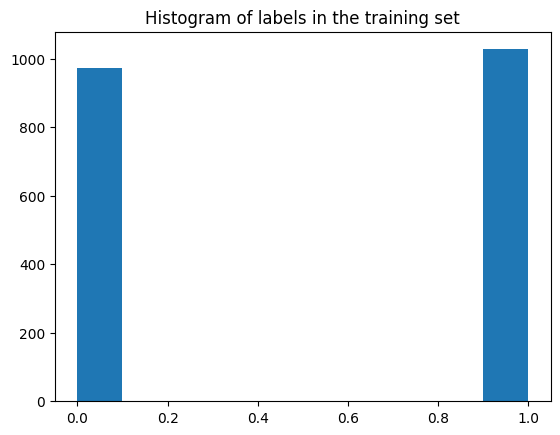

In [30]:
label = node_classif_graph.ndata['label']
plt.hist(label.cpu().detach().numpy())
plt.title('Histogram of labels in the training set')
plt.show()

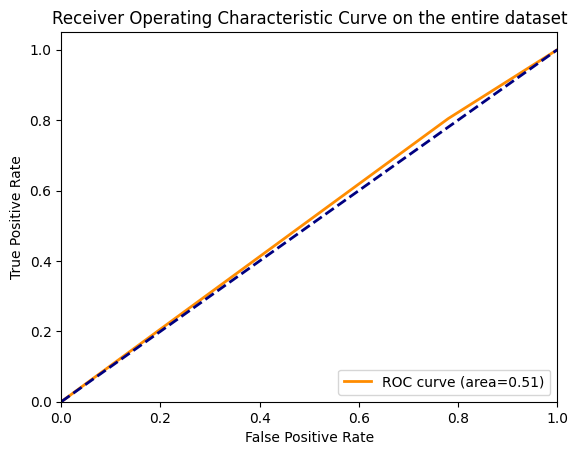

In [31]:
fpr, tpr, _ = roc_curve(label.cpu().detach().numpy(), pred.cpu().detach().numpy())
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area=%0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve on the entire dataset')
plt.legend(loc="lower right")
plt.show()

## Graph Classification

We will fix the number of nodes in each graph (a tunable parameter) and then generate random graphs for each point in the dataset. We will give a label for each such graph.

In [32]:
x_train_small[0].shape

(4,)

In [33]:
class GraphClassificationDataset(dgl.data.DGLDataset):
    def __init__(self):
        super().__init__(name='graph_classification')
        self.num_classes = 2
        self.dim_nfeats = 4

    def process(self):
        self.graphs = []
        self.labels = []
        num_examples = len(x_train_small)
        num_train = int(num_examples * 0.8)
        num_val = int(num_examples * 0.1)
        train_mask = torch.zeros(num_examples, dtype=torch.bool)
        val_mask = torch.zeros(num_examples, dtype=torch.bool)
        test_mask = torch.zeros(num_examples, dtype=torch.bool)
        train_mask[:num_train] = True
        val_mask[num_train:num_train + num_val] = True
        test_mask[num_train + num_val:] = True
        self.train_mask = train_mask
        self.val_mask = val_mask
        self.test_mask = test_mask

        for id in range(len(x_train_small)):
            g = dgl.from_networkx(nx.generators.fast_gnp_random_graph(20, p=0.6))
            g.ndata['feat'] = torch.from_numpy(np.repeat(x_train_small[id].reshape(1, 4), 20, 0))
            g.ndata['label'] = torch.LongTensor([y_train_small[id]]*20)
            self.graphs.append(g)
            self.labels.append(y_train_small[id])

        self.labels = torch.LongTensor(self.labels)
    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

    def __len__(self):
        return len(self.graphs)

In [34]:
graph_classif_dataset = GraphClassificationDataset()
g_sample, label_sample = graph_classif_dataset[0]

In [35]:
print(g_sample, label_sample)

Graph(num_nodes=20, num_edges=240,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}) tensor(1)


In [36]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

num_examples = len(graph_classif_dataset)
num_train = int(num_examples * 0.8)
num_val = int(num_examples * 0.1)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
val_sampler = SubsetRandomSampler(torch.arange(num_train, num_train + num_val))
test_sampler = SubsetRandomSampler(torch.arange(num_train + num_val, num_examples))

train_dataloader = GraphDataLoader(graph_classif_dataset, sampler=train_sampler, batch_size=5, drop_last=False)
val_dataloader = GraphDataLoader(graph_classif_dataset, sampler=val_sampler, batch_size=5, drop_last=False)
test_dataloader = GraphDataLoader(graph_classif_dataset, sampler=test_sampler, batch_size=5, drop_last=False)

In [37]:
it = iter(train_dataloader)
batch = next(it)

In [38]:
print(batch)

[Graph(num_nodes=100, num_edges=1128,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), tensor([0, 1, 1, 1, 1])]


In [39]:
batched_graph, labels = batch
print('Number of nodes for each graph element in the batch:', batched_graph.batch_num_nodes())
print('Number of edges for each graph element in the batch:', batched_graph.batch_num_edges())

Number of nodes for each graph element in the batch: tensor([20, 20, 20, 20, 20])
Number of edges for each graph element in the batch: tensor([232, 236, 238, 232, 190])


In [40]:
graphs = dgl.unbatch(batched_graph)

In [41]:
print('The original graphs in the minibatch:')
print(graphs)

The original graphs in the minibatch:
[Graph(num_nodes=20, num_edges=232,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=20, num_edges=236,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=20, num_edges=238,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=20, num_edges=232,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=20, num_edges=190,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})]


### Model Definition

In [42]:
from dgl.nn import GraphConv

class GraphClassificationModel(torch.nn.Module):
    def __init__(self, in_feats, num_classes):
        super(GraphClassificationModel, self).__init__()
        self.conv1 = GraphConv(in_feats, 16)
        self.conv2 = GraphConv(16, 32)
        self.conv3 = GraphConv(32, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = torch.nn.functional.relu(h)
        h = self.conv2(g, h)
        h = torch.nn.functional.relu(h)
        h = self.conv3(g, h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h')

In [43]:
graph_classif_model = GraphClassificationModel(graph_classif_dataset.dim_nfeats, graph_classif_dataset.num_classes)

### Training Loop

In [44]:
def train(train_loader, val_loader, test_loader, model, num_epochs):
    losses = []
    accs = {'train':[], 'val':[], 'test':[]}
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.9999))
    best_val_acc = 0.0
    best_test_acc = 0.0

    for e in range(num_epochs):
        train_acc_batch = []
        test_acc_batch = []
        val_acc_batch = []
        train_loss_batch = []
        for batched_graph, labels in train_loader:
            model.train()
            batched_graph = batched_graph.to('cuda')
            labels = labels.to('cuda')
            logits = model(batched_graph, batched_graph.ndata['feat'].float())
            pred = logits.argmax(1)
            loss = torch.nn.functional.cross_entropy(logits, labels)
            train_loss_batch.append(loss)
            train_acc = (pred == labels).float().mean()
            train_acc_batch.append(train_acc)
            with torch.no_grad():
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        accs['train'].append(sum(train_acc_batch) / len(train_acc_batch))
        losses.append(sum(train_loss_batch) / len(train_loss_batch))

        model.eval()
        for batched_graph_val, labels_val in val_loader:
            batched_graph_val = batched_graph_val.to('cuda')
            labels_val = labels_val.to('cuda')
            logits_val = model(batched_graph_val, batched_graph_val.ndata['feat'].float())
            pred_val = logits_val.argmax(1)
            val_acc = (pred_val == labels_val).float().mean()
            val_acc_batch.append(val_acc)
        accs['val'].append(sum(val_acc_batch) / len(val_acc_batch))

        for batched_graph_test, labels_test in test_loader:
            batched_graph_test = batched_graph_test.to('cuda')
            labels_test = labels_test.to('cuda')
            logits_test = model(batched_graph_test, batched_graph_test.ndata['feat'].float())
            pred_test = logits_test.argmax(1)
            test_acc = (pred_test == labels_test).float().mean()
            test_acc_batch.append(test_acc)
        accs['test'].append(sum(test_acc_batch) / len(test_acc_batch))

        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        if e % 5 == 0:
            print('In epoch {}, loss: {:.8f}, val acc: {:.8f} (best {:.8f}), test acc: {:.8f} (best {:.8f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))

    return losses, accs

In [45]:
graph_classif_model = graph_classif_model.to('cuda')
graph_classif_losses, graph_classif_accs = train(train_dataloader, val_dataloader, test_dataloader, graph_classif_model, 700)

In epoch 0, loss: 0.66936004, val acc: 0.80000001 (best 0.80000001), test acc: 0.40000001 (best 0.40000001)
In epoch 5, loss: 0.64996165, val acc: 0.60000002 (best 0.80000001), test acc: 0.40000001 (best 0.40000001)
In epoch 10, loss: 0.64356089, val acc: 0.40000001 (best 0.80000001), test acc: 0.60000002 (best 0.40000001)
In epoch 15, loss: 0.71649611, val acc: 0.60000002 (best 1.00000000), test acc: 0.20000000 (best 0.20000000)
In epoch 20, loss: 0.58989656, val acc: 0.80000001 (best 1.00000000), test acc: 0.60000002 (best 0.20000000)
In epoch 25, loss: 0.71100193, val acc: 1.00000000 (best 1.00000000), test acc: 0.20000000 (best 0.20000000)
In epoch 30, loss: 0.68694609, val acc: 0.40000001 (best 1.00000000), test acc: 0.40000001 (best 0.20000000)
In epoch 35, loss: 0.69638854, val acc: 0.60000002 (best 1.00000000), test acc: 0.60000002 (best 0.20000000)
In epoch 40, loss: 0.63779068, val acc: 0.00000000 (best 1.00000000), test acc: 0.80000001 (best 0.20000000)
In epoch 45, loss: 0.

In [46]:
graph_classif_losses = [t.cpu().detach().numpy() for t in graph_classif_losses]

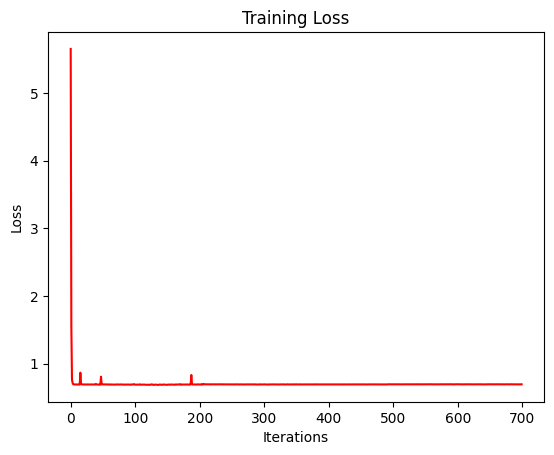

In [47]:
plt.plot(graph_classif_losses, 'r-')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [48]:
graph_classif_accs['train'] = [t.cpu().detach().numpy() for t in graph_classif_accs['train']]

In [49]:
graph_classif_accs['test'] = [t.cpu().detach().numpy() for t in graph_classif_accs['test']]

In [50]:
graph_classif_accs['val'] = [t.cpu().detach().numpy() for t in graph_classif_accs['val']]

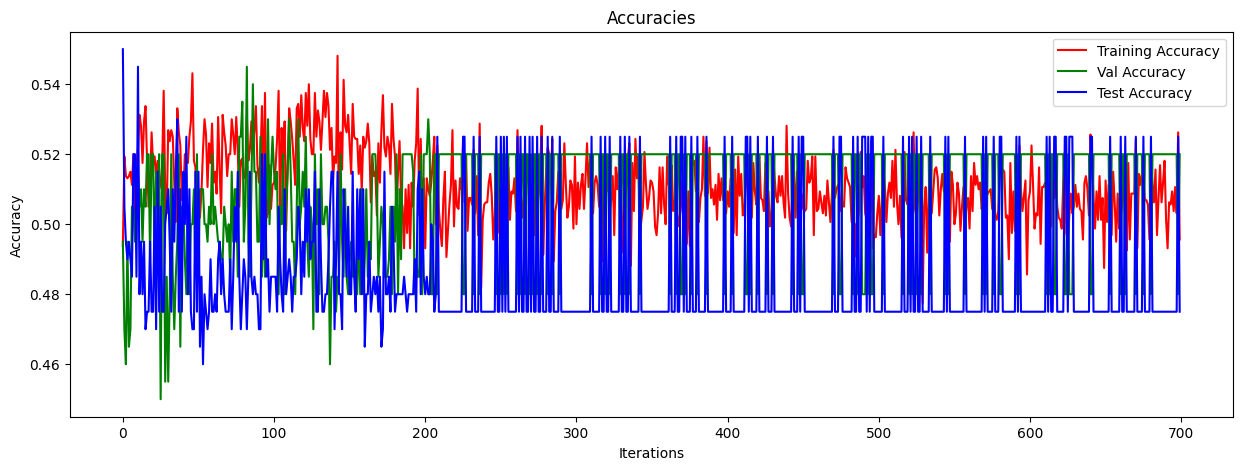

In [51]:
plt.figure(figsize=(15, 5))
plt.plot(graph_classif_accs['train'], 'r-', label='Training Accuracy')
plt.plot(graph_classif_accs['val'], 'g-', label='Val Accuracy')
plt.plot(graph_classif_accs['test'], 'b-', label='Test Accuracy')
plt.title('Accuracies')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [52]:
all_preds_graph_classif = []
for batched_graph_test, labels_test in test_dataloader:
    batched_graph_test = batched_graph_test.to('cuda')
    labels_test = labels_test.to('cuda')
    logits_test = graph_classif_model(batched_graph_test, batched_graph_test.ndata['feat'].float())
    pred_test = logits_test.argmax(1)
    all_preds_graph_classif = all_preds_graph_classif + [*pred_test.cpu().numpy()]

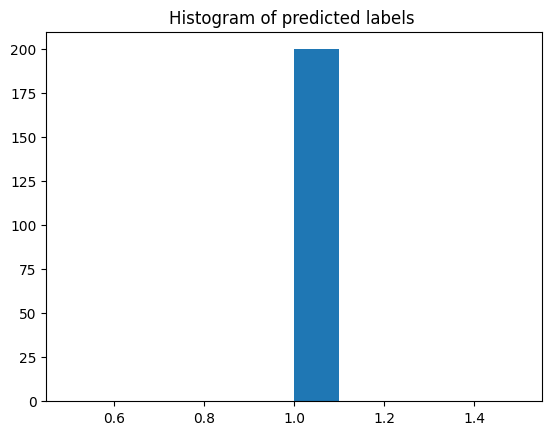

In [53]:
plt.hist(all_preds_graph_classif)
plt.title("Histogram of predicted labels ")
plt.show()

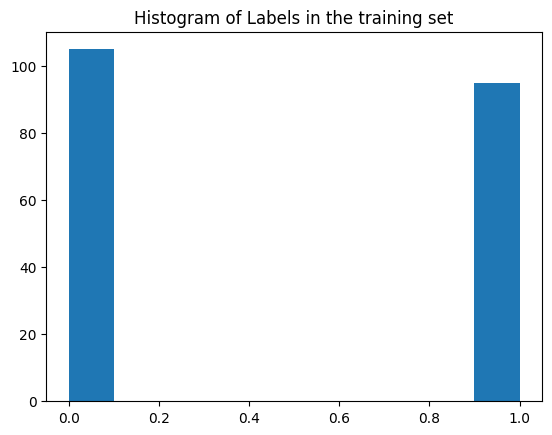

In [54]:
label = graph_classif_dataset.labels[graph_classif_dataset.test_mask]
plt.hist(label.cpu().numpy())
plt.title("Histogram of Labels in the training set")
plt.show()

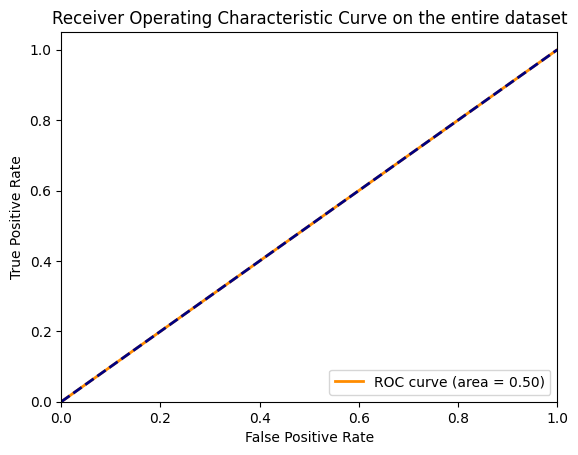

In [55]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, _ = roc_curve(label.cpu().numpy(), all_preds_graph_classif)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve on the entire dataset')
plt.legend(loc="lower right")
plt.show()

## Comparison

Both the node and graph classification worked for the classification task but graph classification is found to give inferior performance compared to node classification.

This might be due to:
1. Less number of epochs:

 I took less number of epochs for the graph classification model because the GPU on colab goes out of memory on number of epochs greater than 750

## Possible Improvements

1. Implementing neural message passing models which have shown good results on jet classification tasks

2. Studying and applying better ways of encoding the train data in the form of graphs